In [ ]:
# Process FITBIT's json heart rate files
# Usually one activity per file, and creates a dataframe per activity
# Heart rates with low confidence are not included in the dataframe
# If there are no high confidence heart rates, the dataframe is not used

# The process checks that there are no long periods with no activity in the dataframe
# If there is such a period, a new activity dataframe after the silent period is created

# The process also removes short activities 

# reset_indexing of the dataframe is used often to prevent warrnings, see:
# http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import glob
import pickle
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters

In [2]:
# Settings for high/low confidence, long silent period, short time activity, peak zone

confidnece_limit = 1  #0, 1 - low confidence; 2,3 - high confidence
silent_time_limit = "20 minutes"
short_time_limit = "5 minutes"
peak_zone_limit=135 # For me

# Functions

In [ ]:
def processHeartRate(df):
    
    df['Date'] = pd.to_datetime(df['dateTime']).dt.date
    df['Time'] = pd.to_datetime(df['dateTime']).dt.time
    
    # Copying the dict values to the dataframe, based on:
    # https://stackoverflow.com/questions/29681906/python-pandas-dataframe-from-series-of-dict
    
    temp_df = pd.DataFrame(list(df['value']))
    df['BPM']=temp_df['bpm']
    df['Confidence']=temp_df['confidence']
 
    # Cleans the data frame from low confidence heart rates
    # The if clause prevents removing all items and returning an empty df
    # The dfExists flag indicates that there is no valid dataframe
    # The reset_index create a new continuos index starting with zero   
     
    dfTemp=df[df[:]['Confidence']>confidnece_limit]
    
    if len(dfTemp)>1:
        dfExists=True
        dfNew=dfTemp.reset_index(drop=True)
    else:
        #print('File with only low confidnece readings',df.iloc[0]['Date'],end=' ')
        dfExists=False
        dfNew=df
    
    return dfExists, dfNew

In [ ]:
def calculateSummery(df):
    
    Date=df.iloc[0]['Date'] # Assumes a single date along the dataframe
    
    Duration= datetime.combine( Date, df['Time'].max() ) - datetime.combine( Date,df['Time'].min() )
    MeanBPM=round(df['BPM'].mean(),0)
    MaxBPM=df['BPM'].max()
    
    peak1=df['BPM']>peak_zone_limit
    peak2=peak1.value_counts()
    try:
        PeakZone=peak2[True]
    except KeyError:
        PeakZone=0
        
    String= str(df.iloc[0]['Date']) + ' ' + str(Duration) + ' ' + str(MeanBPM)   
    Summary = {'string': String, 'date': Date, 'meanBPM': MeanBPM, 'maxBPM': MaxBPM,\
               'duration':Duration, 'peakZone': PeakZone}

    return Summary

In [ ]:
# Each json heart rate file covers a day; this function identifies days with more than one activity
# Uses a hurisitc, that there is no data for more than 20 minutes, to divide into a new activity

def identifySilentTime(df):
    
    breakExists=False
    j=0
    for i in range(len(df)-1):
        delta=df.iloc[i+1]['dateTime'] - df.iloc[i]['dateTime']
        if (delta>pd.Timedelta(silent_time_limit)):
            #print('BREAK ',i,df.iloc[i]['Time'],df.iloc[i+1]['Time'])
            breakExists=True
            j=i
            break
    return breakExists,j

# Main: Process

In [ ]:
start=0           # File number to start from 
end=293           # Process n files

In [ ]:
files=glob.glob("DATA\heart_rate*.json")

filesToRead=files[start:end]
print('files',len(files),'start',start,'end',end, 'files to read',len(filesToRead))

In [ ]:
DFs=[]
Summaries=[]

print('Process monitoring, file numbers: - standard df, / time break dfs, no df *')
readNewFile=True
i=0
while (i< len(filesToRead)) or (not readNewFile): 
        
    if (readNewFile):
        df0=pd.read_json(filesToRead[i])
        i+=1 # Next file 
        
    dfExists, df = processHeartRate(df0)
    
    if (dfExists):
                
        breakExists,breakIndex=identifySilentTime(df)
        if (breakExists):
            df1=df[0:breakIndex+1]
            df0=df[breakIndex+1:].reset_index(drop=True)
            readNewFile=False
            print(i-1,end='/')
        else: # (NOT breakExists)
            df1=df
            readNewFile=True
            print(i-1,end='-')
        # IF (breakExists) ends
        
        DFs.append(df1)
        summary = calculateSummery(df1)
        Summaries.append(summary)
    
    else: # (NOT dfExists)
        print(i-1,end='*')
        readNewFile=True
    # IF (dfExists) ends
    
# WHILE ends 
print('\nlen(DFs),len(Summaries)',len(DFs),len(Summaries))

In [ ]:
# Remove short sequences

for idx, d in enumerate(Summaries):
    delta=d['duration']
    if (delta<pd.Timedelta(short_time_limit)):
        print(idx,end=' ')
        del Summaries[idx]
print('\n Summaries',len(Summaries))

for idx, df in enumerate(DFs):
    Date=df.iloc[0]['Date']
    delta=datetime.combine( Date, df['Time'].max() ) - datetime.combine( Date,df['Time'].min() )
    if (delta<pd.Timedelta(short_time_limit)):
        print(idx,end=' ')
        del DFs[idx]
print('\n DFs',len(DFs))

In [ ]:
pickle.dump(DFs, open('DFs.pkl', 'wb'))
pickle.dump(Summaries, open('Summaries.pkl', 'wb'))

# Plot Summaries

In [3]:
DFs=pickle.load(open('DFs.pkl', 'rb'))
Summaries=pickle.load(open('Summaries.pkl', 'rb'))
print(len(DFs),len(Summaries))

325 325


In [4]:
myFormat = DateFormatter("%d-%m")
register_matplotlib_converters(myFormat)

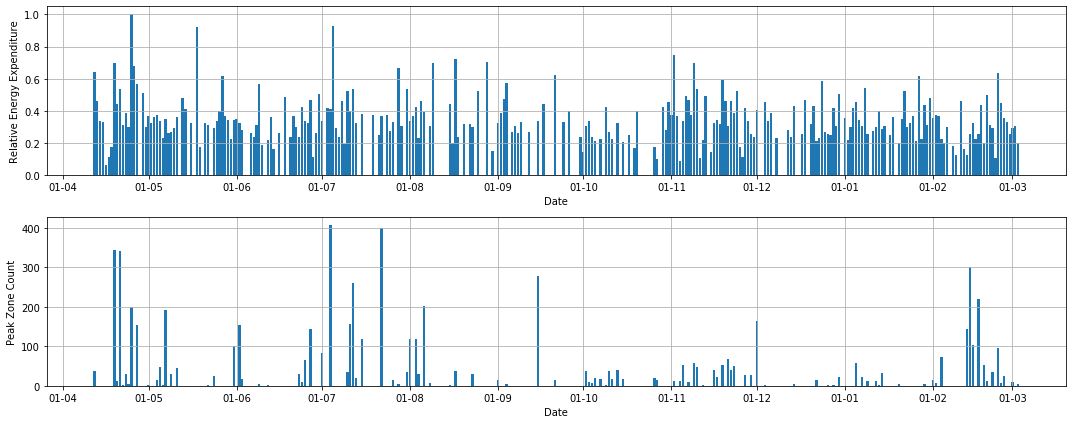

In [5]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15, 2*3) )

x=[d['date'] for d in Summaries]

y1=[d['duration'].total_seconds()/60 for d in Summaries]
y1[22]=200        # Cap a single large item, to get clearer plots
y2=[d['meanBPM'] for d in Summaries]

# Research showed that wrist-worn heart-rate measures are quite accurate, but energy expenditure measures are not. 
# I am looking for a simple reliable formula, but for now I plot the relative energy expenditure in this dataset
# I first assume that energy expenditure is proportional to heart rate (first degree)
# See: Shcherbina, A. et al. (2017). Accuracy in wrist-worn, sensor-based measurements of heart rate 
# and energy expenditure in a diverse cohort. Journal of personalized medicine, 7(2), 3.

y=np.array(y1)*np.array(y2) # duration*meanBPM
m=y.max()
y3=y/m

axs[0].bar(x,y3)
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Relative Energy Expenditure')
axs[0].grid(True)  
axs[0].xaxis.set_major_formatter(myFormat)

# Now I am interested in high high heart-rate activities; I count heart rate instances above the Peak Zone limit 
# The count should be transformed to time, but it is used to get an impression of high intensity activities
# I still am looking for a better way to model the non-linear effect of heart rate 

y4=[d['peakZone'] for d in Summaries]
axs[1].bar(x,y4)
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Peak Zone Count')
axs[1].grid(True)  
axs[1].xaxis.set_major_formatter(myFormat)

fig.tight_layout()
plt.show()

# Plot Heart Rates (Functions)

In [19]:
#%matplotlib inline

def plotHeartRate(toPlot, DFs,Summaries):

    nPlots=len(toPlot)
    print('nPlots',nPlots)
    fig, axs = plt.subplots(nrows=nPlots, ncols=1, figsize=(15, 2*nPlots) )

    myFormat = DateFormatter("%H:%M")
    register_matplotlib_converters(myFormat)

    i=0
    for index in toPlot:
        df=DFs[ index ]
        summary=Summaries[ index ]
        axs[i].plot(df['dateTime'], df['BPM'])
        axs[i].set_xlabel('Time')
        axs[i].set_ylabel('BPM')
        axs[i].set_title( summary['string'] )
        axs[i].grid(True)
        axs[i].xaxis.set_major_formatter(myFormat)
        i+=1
        
    fig.tight_layout()
    plt.show()

# end plotHeartRate

In [32]:
# https://github.com/oemof/cydets

from cydets.algorithm import detect_cycles

def processCycles(toPlot,DFs,Summaries):

    nPlots=len(toPlot)
    for index in toPlot:
        df=DFs[ index ]
        summary=Summaries[ index ]
        
        series = pd.Series(df['BPM'])
        cycles = detect_cycles(series,integer_index=True)

        d=cycles['duration']
        print(summary['string'],'   number of cycles ',len(d),'median cycle duration ',d.median(),)
          
# end processCycles

# Plot Heart Rates (Main)

nPlots 5


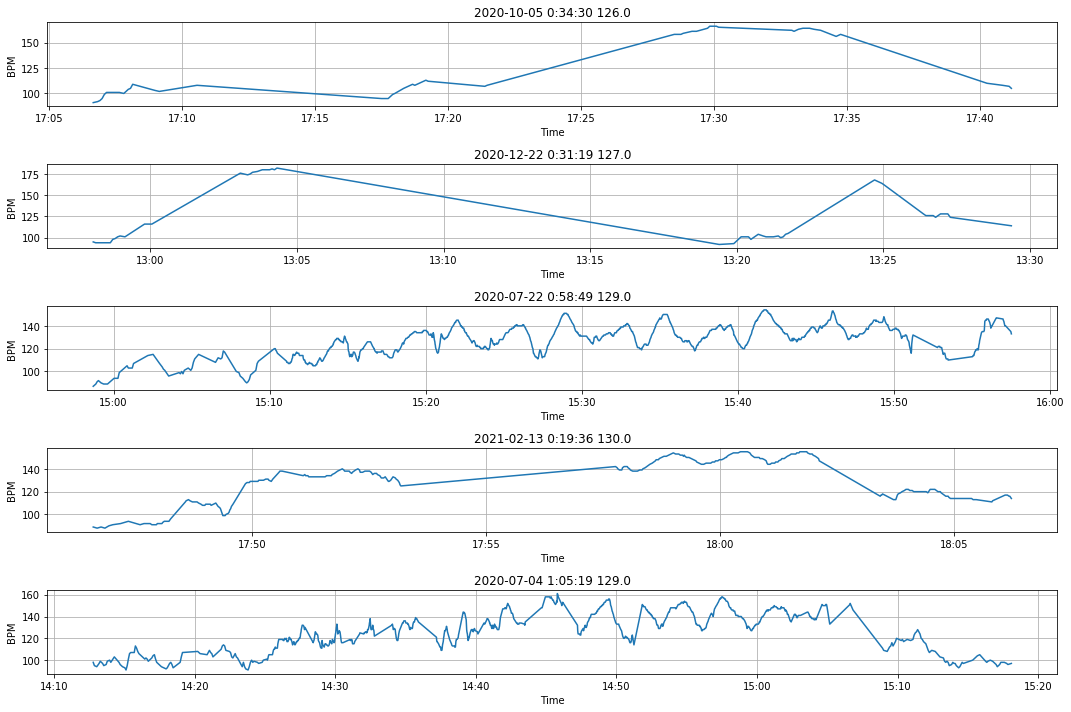

In [33]:
# Plot activities with HIGHEST mean heart rate

# argpartition is used to collect the right indices, see:
#https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array

y=[d['meanBPM'] for d in Summaries]
y=np.array(y)
#print(np.sort(y))

nPlots=5

toPlot=np.argpartition(y, -nPlots)[-nPlots:]
#print('\n',toPlot,'\n',y[toPlot],'\n',np.sort(y[toPlot]))

plotHeartRate(toPlot,DFs,Summaries)

In [35]:
processCycles(toPlot,DFs,Summaries)

2020-10-05 0:34:30 126.0    number of cycles  7 median cycle duration  5.0
2020-12-22 0:31:19 127.0    number of cycles  9 median cycle duration  8.0
2020-07-22 0:58:49 129.0    number of cycles  70 median cycle duration  20.0
2021-02-13 0:19:36 130.0    number of cycles  25 median cycle duration  14.0
2020-07-04 1:05:19 129.0    number of cycles  95 median cycle duration  11.0


nPlots 5


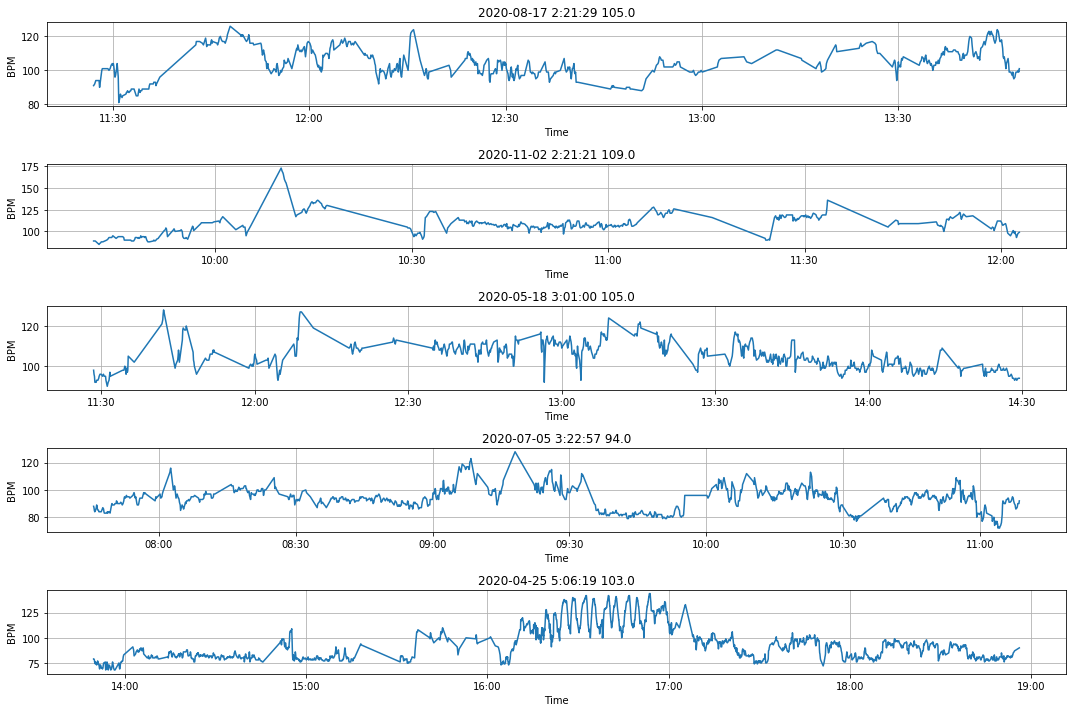

In [36]:
# Plot activities with HIGHEST energy expenditure

y1= np.array( [d['meanBPM'] for d in Summaries] )
y2=[d['duration'].total_seconds()/60 for d in Summaries]
y=y1*y2

nPlots=5

toPlot=np.argpartition(y, -nPlots)[-nPlots:]
#print('\n',toPlot,'\n',y[toPlot],'\n',np.sort(y[toPlot]))

plotHeartRate(toPlot,DFs,Summaries)

In [37]:
processCycles(toPlot,DFs,Summaries)

2020-08-17 2:21:29 105.0    number of cycles  128 median cycle duration  5.0
2020-11-02 2:21:21 109.0    number of cycles  108 median cycle duration  5.0
2020-05-18 3:01:00 105.0    number of cycles  143 median cycle duration  7.0
2020-07-05 3:22:57 94.0    number of cycles  215 median cycle duration  6.0
2020-04-25 5:06:19 103.0    number of cycles  328 median cycle duration  8.0


nPlots 5


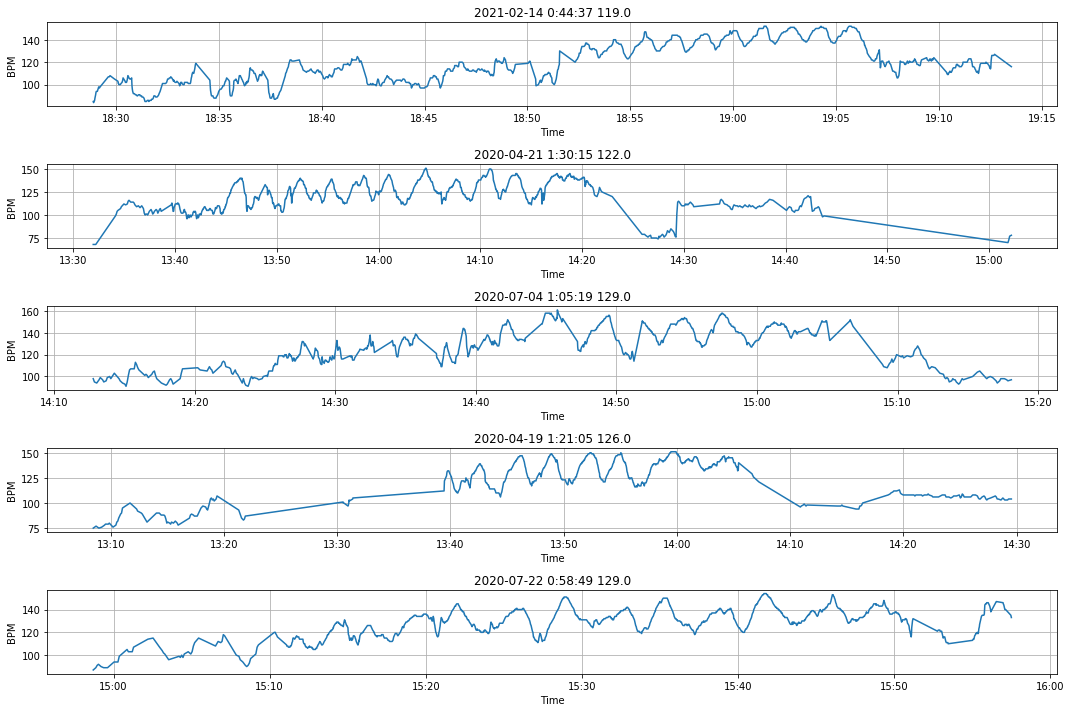

In [38]:
# Plot activities with HIGHEST peak zone count

y= np.array( [d['peakZone'] for d in Summaries] )

nPlots=5

toPlot=np.argpartition(y, -nPlots)[-nPlots:]
#print('\n',toPlot,'\n',y[toPlot],'\n',np.sort(y[toPlot]))

plotHeartRate(toPlot,DFs,Summaries)

In [39]:
processCycles(toPlot,DFs,Summaries)

2021-02-14 0:44:37 119.0    number of cycles  94 median cycle duration  11.0
2020-04-21 1:30:15 122.0    number of cycles  97 median cycle duration  14.0
2020-07-04 1:05:19 129.0    number of cycles  95 median cycle duration  11.0
2020-04-19 1:21:05 126.0    number of cycles  55 median cycle duration  11.0
2020-07-22 0:58:49 129.0    number of cycles  70 median cycle duration  20.0


In [ ]:
# SKIPPED

# Plot only a few of the detailed heart rate sequences

start1=300        # Uses the file numbers from the cell above
end1=325            # but can be changed

DFs=pickle.load(open('DFs.pkl', 'rb'))
Summaries=pickle.load(open('Summaries.pkl', 'rb'))

DFs=DFs[start1:end1]
Summaries=Summaries[start1:end1]
nPlots=len(DFs)
print(len(DFs),len(Summaries))

In [ ]:
# SKIPPED

# Plot activities with LOWEST mean heart rate

# argpartition is used to collect the right indices, see:
#https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array

y=[d['meanBPM'] for d in Summaries]
y=np.array(y)
#print(np.sort(y))

nPlots=5

toPlot=np.argpartition(y, nPlots)[:nPlots]
#print('\n',toPlot,y[toPlot])

plotHeartRate(toPlot,DFs,Summaries)